In [255]:
import pandas as pd
import ast

df = pd.read_csv("data/small.csv")
doi_list = df['doi'].to_list()

In [256]:
def get_name(doi):
    # print(df.loc[df['doi'] == doi].title.values[0])
    return df.loc[df['doi'] == doi].title.values[0]

graph = {
    "nodes": [{ "id": doi, "name": get_name(doi)} for doi in doi_list],
    "links": []
}

In [257]:
# loop through df
for index, row in df.iterrows():
    # print(row.references)
    # print(ast.literal_eval(row.references))
    references = ast.literal_eval(row.references)
    for ref in references:
        if(ref in doi_list):
            graph["links"].append({"source": row.doi, "target": ref})

100%|██████████| 5000/5000 [00:24<00:00, 201.50it/s]


BarnesHut Approximation  took  3.24  seconds
Repulsion forces  took  19.90  seconds
Gravitational forces  took  0.21  seconds
Attraction forces  took  0.10  seconds
AdjustSpeedAndApplyForces step  took  0.90  seconds


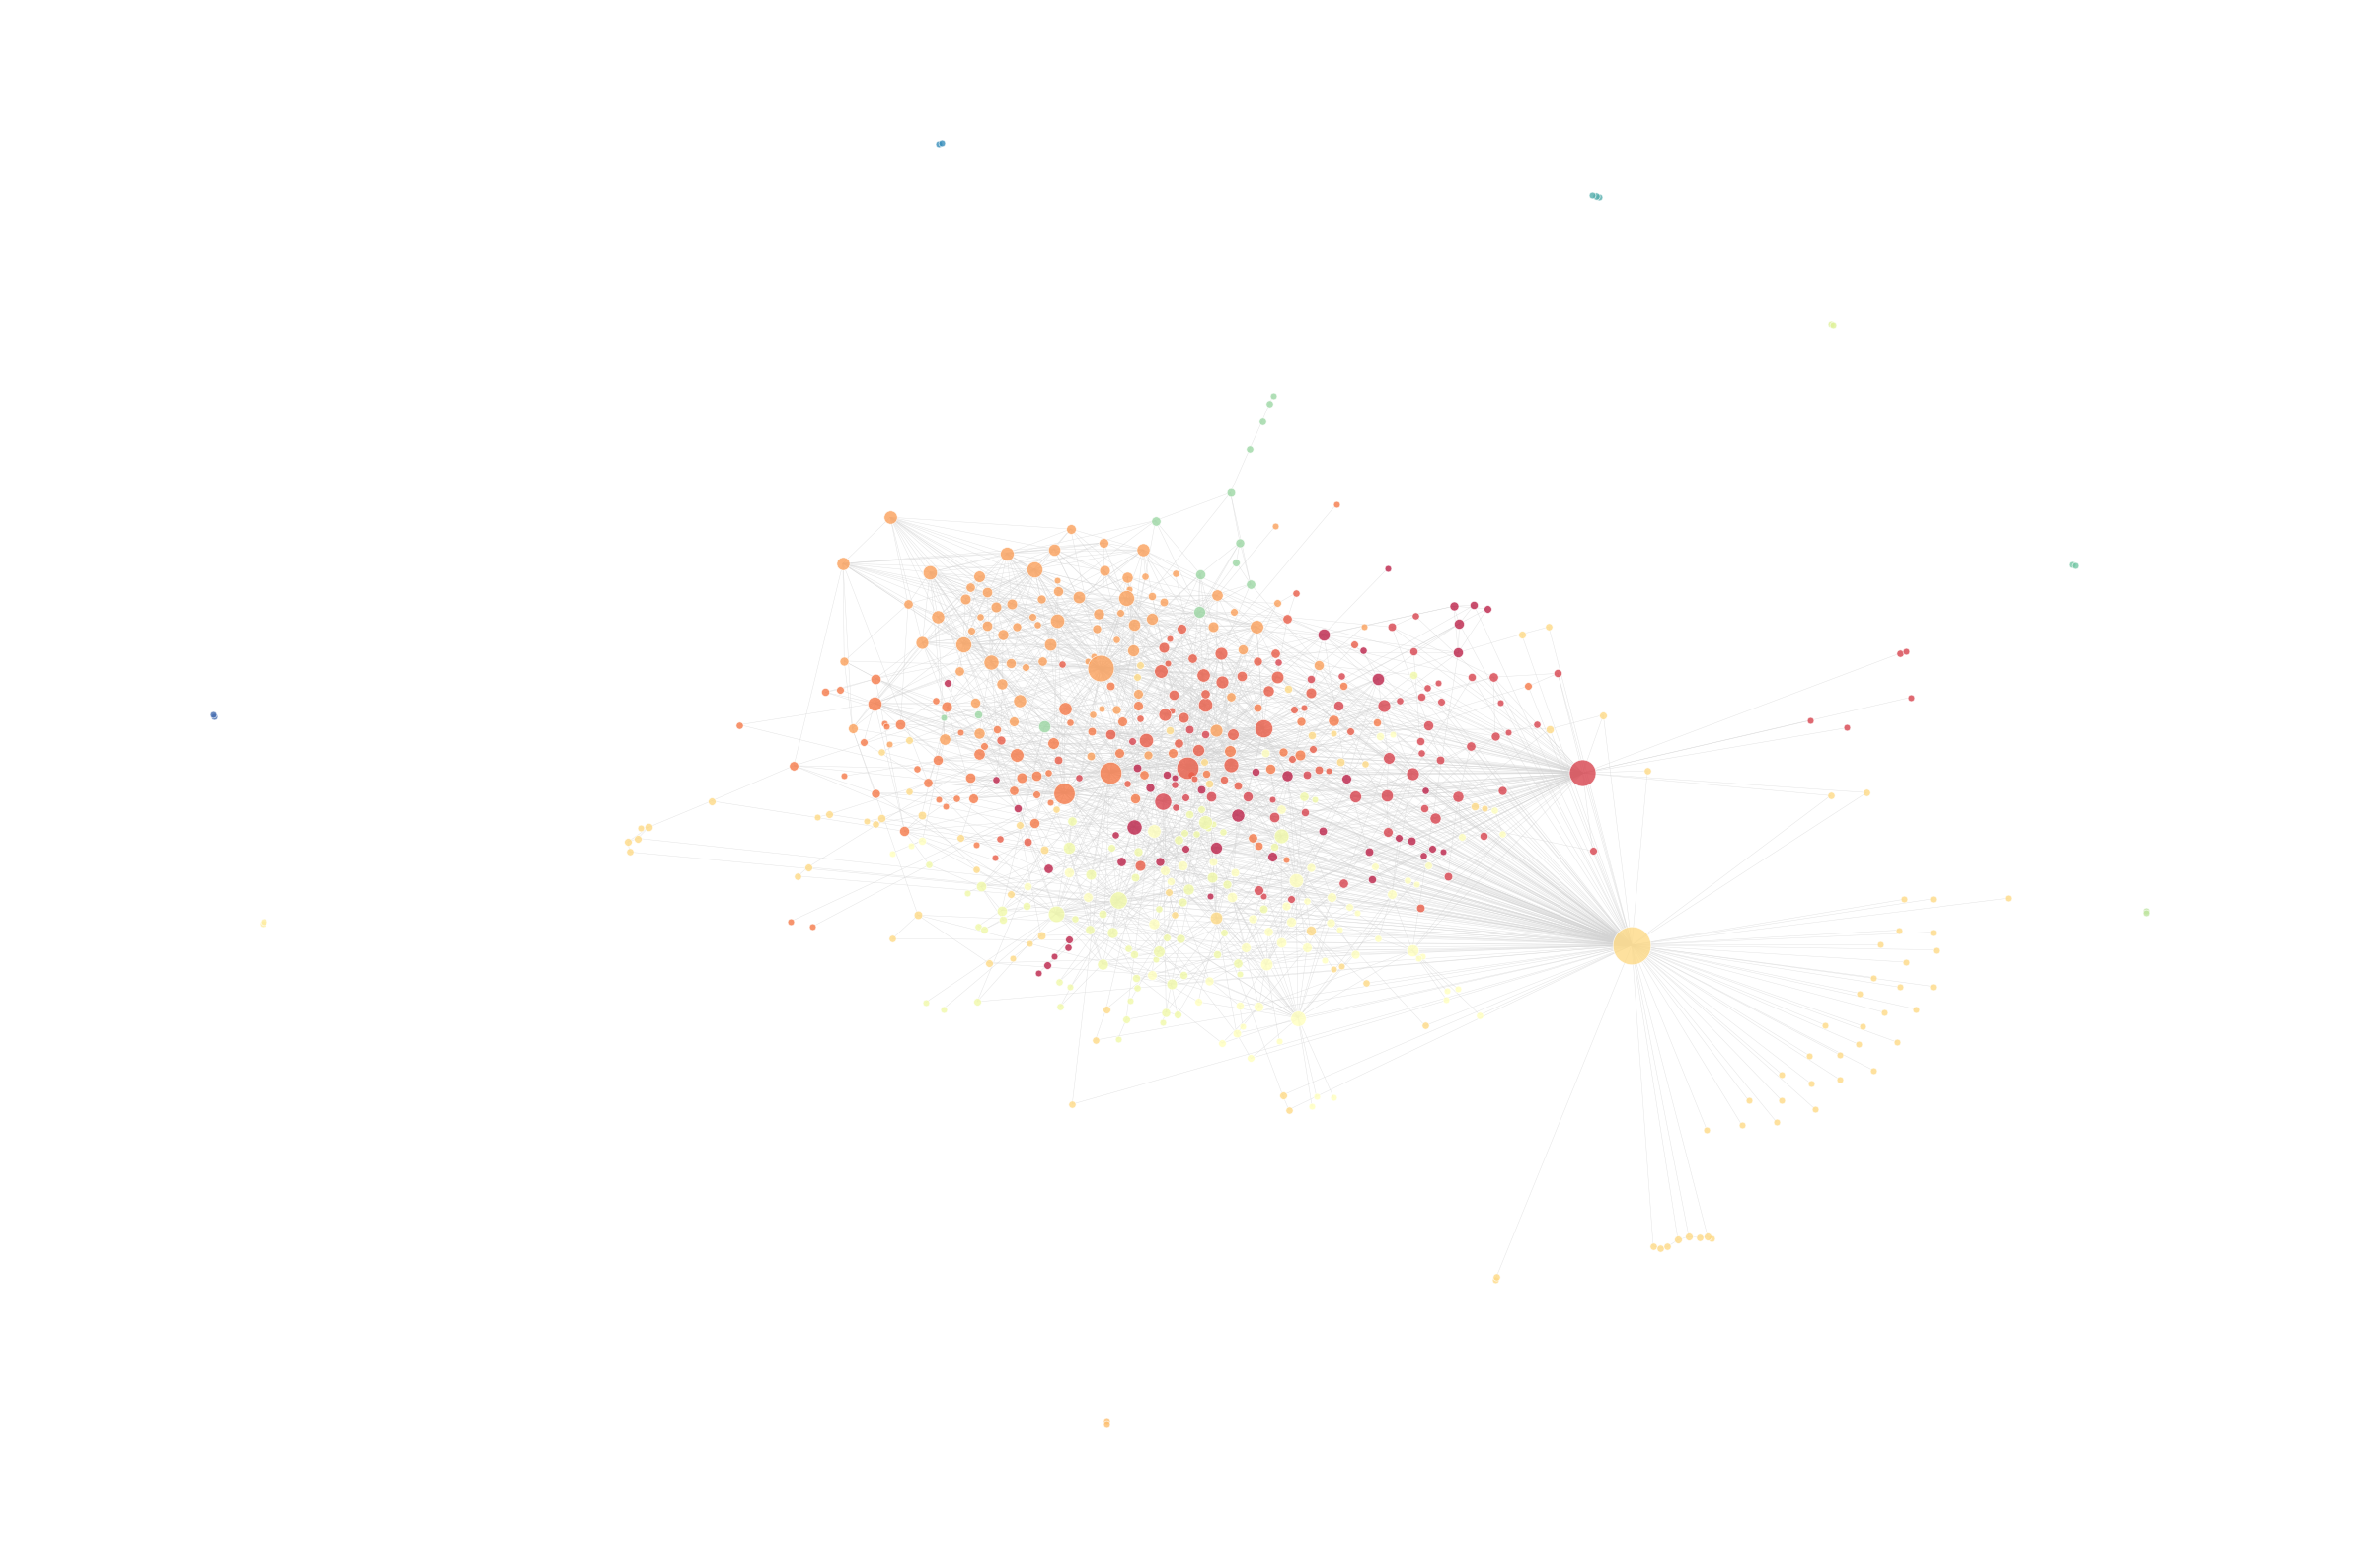

Number of communities: 17
Largest community size: 102
Smallest community size: 2
Total nodes in connected components: 571


In [333]:
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns
from fa2_modified import ForceAtlas2
import numpy as np

# Assume 'graph' is your existing graph structure
G = nx.Graph()

# Add nodes and edges
for node in graph['nodes']:
    G.add_node(node['id'], name=node['name'])
for link in graph['links']:
    G.add_edge(link['source'], link['target'])

# Remove isolated nodes
G.remove_nodes_from(list(nx.isolates(G)))

# Detect communities
partition = community_louvain.best_partition(G)

# ForceAtlas2 layout configuration
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=True,
    linLogMode=False,
    adjustSizes=False,
    edgeWeightInfluence=1.0,
    jitterTolerance=1.0,
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,
    scalingRatio=100,  # Dramatically increased for much more spread
    strongGravityMode=False,
    gravity=100,  # Further reduced to allow even more spread
    verbose=True
)

positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=5000)

# Set up the plot
plt.figure(figsize=(24, 16), facecolor='white')  # Even larger figure size

# Draw edges
nx.draw_networkx_edges(G, positions, alpha=0.7, edge_color='lightgray', width=0.3)

# Get node sizes based on degree centrality
degrees = dict(G.degree())
max_degree = max(degrees.values())
node_sizes = [min(20 + ((v / max_degree) * 0.8) * 1500, 800) for v in degrees.values()]  # Increased base size and scaling

# Create a color palette for nodes
unique_communities = sorted(set(partition.values()))
num_communities = len(unique_communities)
palette = sns.color_palette("Spectral", n_colors=num_communities)
color_map = dict(zip(unique_communities, palette))

# Draw nodes
for node, community in partition.items():
    nx.draw_networkx_nodes(G, positions, 
                           nodelist=[node],
                           node_size=node_sizes[list(G.nodes()).index(node)],
                           node_color=[color_map[community]],
                           alpha=0.8,
                           edgecolors='white',
                           linewidths=0.5)

plt.axis('off')
plt.tight_layout()

# Remove legend
plt.gca().legend_ = None

plt.show()

# Print community statistics
community_sizes = {}
for community in set(partition.values()):
    size = list(partition.values()).count(community)
    community_sizes[community] = size
print("Number of communities:", len(community_sizes))
print("Largest community size:", max(community_sizes.values()))
print("Smallest community size:", min(community_sizes.values()))
print("Total nodes in connected components:", len(G.nodes()))